In [1]:
%matplotlib inline
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
from matplotlib import pyplot as plt
import pyshtools as sht
import numpy as np

Loading SHTOOLS documentation


In [2]:
coeffs,errors,lmax = sht.SHReadError('EGM2008_to2190_ZeroTide.shm',2159)

In [3]:
# These are appropriate values for the GRS80 model
omega_earth = 7.292115e-5
a_earth = 6378137.
b_earth = 6356752.3141
GM_earth = 3.986005e14
f_earth = 0.003352810681183637418
pot_ref_geoid_earth = 6263686.0850E1

print a_earth - sht.constant.r0_pot_earth


0.700000000186


In [19]:
# These are appropriate values for the WGS84 model
omega_earth = 7.2921151467e-5
a_earth = 6378137.
GM_earth = 3.986004418e14
inverse_flattening = 298.257223563
f_earth = 1./inverse_flattening

print a_earth - sht.constant.r0_pot_earth


0.700000000186


In [4]:
geoid = sht.MakeGeoidGridDH(coeffs,
                            r0pot = a_earth,
                            GM = GM_earth,
                            PotRef=pot_ref_geoid_earth,
                            omega=omega_earth,
                            a = a_earth,
                            f = f_earth,
                            order=2)

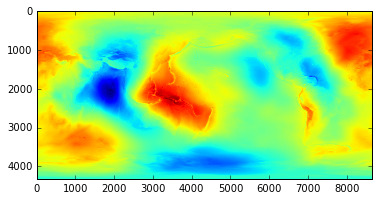

In [5]:
plt.imshow(geoid)

In [6]:
nlat,nlon = geoid.shape
dlat = 360. / nlat
lats = np.linspace(0. + (dlat / 2.), 360. - (dlat / 2.), nlat)
normal_gravs = [sht.NormalGravity(lat,GM_earth,omega_earth,a_earth,b_earth) for lat in lats]
ng = np.array(normal_gravs,np.float64)
#print normal_gravs

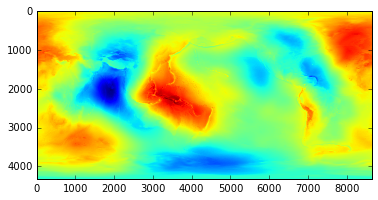

In [8]:
# Brun's formula
T = geoid * ng[:,np.newaxis]
fig = plt.figure()
plt.imshow(T)
#fig.savefig('Timage.png')

In [9]:
T_SH = sht.SHExpandDH(T)

This next function computes the distance from the North Pole on a sphere of radius $R_e$ to all points on a concentric sphere of radius $r_i$. 

Let $\theta$ = the co-latitude (ranging from 0 at the North Pole to $\pi$ at the South Pole).

Let $R_e$ be the radius of an external sphere with center at the origin. (The subscript e for either Earth or external...)

Let $r_i$ be the radius of an internal sphere concentric with the external one, with the vector ${\bf r}_i$ ending at an arbitrary point on the internal sphere. The length $|{\bf r}_i| = r_i$. We also assume that there is some mass located at ${\bf r}_i$. The distribution of these masses over all orientations of ${\bf r}_i$ and for all internal spheres is the object of our tomography. 

Let the $z$ axis be positive through the North Pole.

Let $r_a$ be the distance along the $z$ axis from the North Pole to the base of the vector perpendicular to the $z$ axis that ends at the position vector ${\bf r}_i$. Also let $r_b$ be the (perpendicular) distance from the $z$ axis to the position vector ${\bf r}_i$.

Finally, let $r_{pm}$ be the distance from the North Pole to a mass located at position vector ${\bf r}_i$.

Then $r_a = R_e - r_i \cos \theta$, $r_b = r_i \sin \theta$, and $r_{pm} = \sqrt{r_a^2 + r_b^2} = \sqrt{(R_e - r_i \cos \theta)^2 + (r_i \sin \theta)^2} = \sqrt{R_e^2 + r_i^2 - 2 r_i R_e \cos \theta}$.

In [10]:
def make_Rpm(R_e,r_i,co_lats,shp):
    rpm_1D = np.sqrt(-2.*r_i*R_e*np.cos(co_lats) + R_e**2 + r_i**2 )
    rpm_2D = np.zeros(shp,np.float64)
    rpm_2D[:,:] = rpm_1D[:,np.newaxis]
    
    return rpm_2D

In [11]:
co_lats = np.linspace(0.,np.pi,num=T.shape[0],endpoint=True)

In [12]:
rpm_2D = -make_Rpm(R_e = 6371000., r_i = 0.985*6371000., co_lats = co_lats, shp = T.shape)

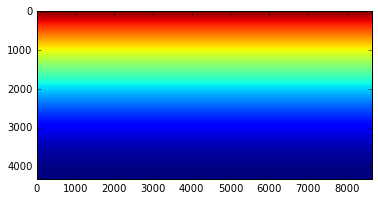

In [13]:
plt.imshow(rpm_2D)

In [14]:
rpm_2D_SH = sht.SHExpandDH(rpm_2D)

In [15]:
kernel =  rpm_2D_SH[0,:,0]
print kernel.shape

(2160,)


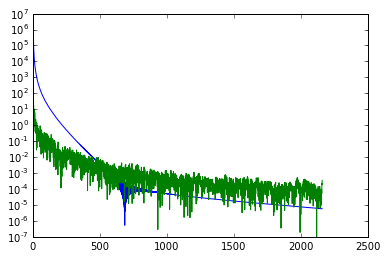

In [16]:
plt.semilogy(np.abs(kernel))
plt.semilogy(np.abs(T_SH[0,:,0]))


In [17]:
convolved = kernel[np.newaxis,:,np.newaxis] * T_SH

print convolved[:,0:5,0:5]
convolved[:,1,1] = 0.

[[[ -1.47477264e+08  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    -0.00000000e+00]
  [ -4.29178836e+07   5.98700888e+08   0.00000000e+00   0.00000000e+00
     0.00000000e+00]
  [ -1.29522471e+06   2.60642518e+07  -4.76319011e+07   0.00000000e+00
     0.00000000e+00]
  [  9.10836490e+06  -7.43813267e+06  -7.72509394e+06   2.61151948e+06
     0.00000000e+00]
  [ -2.39483921e+06   5.54784712e+06   1.12714153e+06   2.32012262e+05
    -2.86051487e+05]]

 [[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    -0.00000000e+00]
  [  0.00000000e+00  -2.97179627e+08   0.00000000e+00   0.00000000e+00
     0.00000000e+00]
  [  0.00000000e+00  -3.81097044e+07   1.75251796e+07   0.00000000e+00
     0.00000000e+00]
  [  0.00000000e+00   3.67050777e+07   1.19953753e+07   7.86112076e+05
     0.00000000e+00]
  [  0.00000000e+00  -3.11973996e+06  -9.82312017e+05   1.98325790e+06
     1.35586061e+06]]]


In [18]:
tomo_r1 = sht.MakeGridDH(convolved,sampling=2,csphase=1)

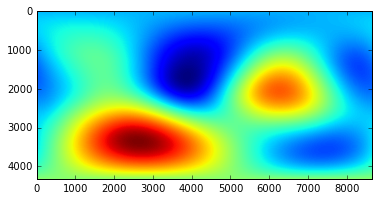

In [19]:
plt.imshow(tomo_r1)

In [20]:
ramp_filter = np.linspace(0.,1.,num=convolved.shape[1],endpoint=True)

cone_filter_2d = np.sqrt(np.outer(ramp_filter*ramp_filter,ramp_filter*ramp_filter))

In [21]:
filtered_convolved = cone_filter_2d[np.newaxis,:,:]* convolved

In [22]:
tomo_r2_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1)

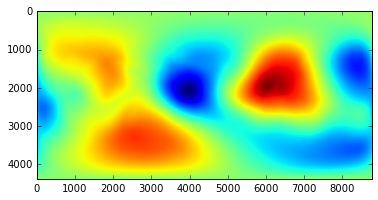

In [2]:
plt.imshow(tomo_r1_filtered)

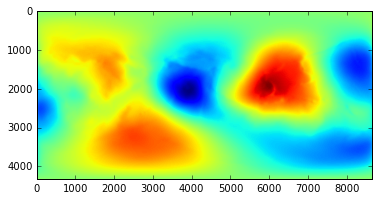

In [23]:
plt.imshow(tomo_r2_filtered)

In [1]:
%matplotlib inline
%run GravTomo.py

Loading SHTOOLS documentation




**Old dead code only below here. Mostly preserved for examples of calling routines...**